In [1]:
%pylab inline
import numpy as np
import torch

from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import dataloader

from torchvision import transforms
from torchvision.datasets import MNIST, FashionMNIST

from sklearn.metrics import accuracy_score
from collections import deque

from graphviz import Digraph

Populating the interactive namespace from numpy and matplotlib


# Configuration

In [2]:
BATCH_SIZE = 256

# Data

In [3]:
train = FashionMNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = FashionMNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE ,num_workers=1, pin_memory=True)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

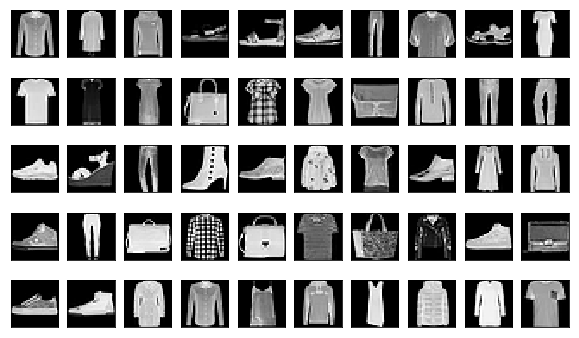

In [4]:
def visualize_data(data):
    N = data.size()[0]
    
    fig, subplots = plt.subplots(5, 10)
    fig.set_figheight(6)
    fig.set_figwidth(10)
    subplots = subplots.reshape(-1)
    
    for subplot in subplots:
        idx = np.random.randint(0, N)
        img = train.train_data[idx].numpy()
        
        subplot.get_xaxis().set_visible(False)
        subplot.get_yaxis().set_visible(False)
        subplot.imshow(img, cmap='gray')
        
visualize_data(train.train_data)

# Model

## Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self, channel:int=256):
        super(Discriminator, self).__init__()
        np.random.seed(0)
        torch.manual_seed(0)
        
        self.channel:int = channel
        n_class:int = 1 # 1=진짜, 0=가짜 이기 때문에 1값으로 둔다.
        
        self.conv1 = nn.Conv2d(1, channel//4, kernel_size=6, stride=1, padding=2)
        self.conv2 = nn.Conv2d(channel//4, channel//3, kernel_size=5, stride=2, padding=4)
        self.bn2 = nn.BatchNorm2d(channel//3)
        self.conv3 = nn.Conv2d(channel//3, channel//2, kernel_size=4, stride=2, padding=4)
        self.bn3 = nn.BatchNorm2d(channel//2)
        self.conv4 = nn.Conv2d(channel//2, channel, kernel_size=4, stride=2, padding=4)
        self.bn4 = nn.BatchNorm2d(channel)
        
        # Global Average Pooling
        self.conv5 = nn.Conv2d(channel, n_class, kernel_size=4, stride=2, padding=4)

    def forward(self, x, _return_activations=False):
        h1: Variable = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        h2: Variable = F.leaky_relu(self.bn2(self.conv2(h1)), negative_slope=0.2)
        h3: Variable = F.leaky_relu(self.bn3(self.conv3(h2)), negative_slope=0.2)
        h4: Variable = F.leaky_relu(self.bn4(self.conv4(h3)), negative_slope=0.2)
        
        # Global Average Pooling
        h5 = F.leaky_relu(self.conv5(h4), negative_slope=0.2)
        gap = F.avg_pool2d(h5, kernel_size=h5.size()[2:]).view(h5.size()[0], -1)
        output = F.sigmoid(gap)
        
        if _return_activations:
            return output, [h4, h5, gap]
        
        return output
    
    def feature_mapping(self, real, fake):
        _, real_fs = self.forward(real, _return_activations=True)
        _, fake_fs = self.forward(fake, _return_activations=True)
        
        diffs = []
        for real, fake in zip(real_fs, fake_fs):
            diff = torch.mean(torch.pow(real - fake, 2))
            diffs.append(diff)
        
        output = torch.sqrt(torch.mean(torch.stack(diffs)))
        
#         print('x'*50)
#         output.backward()
#         print(fake.grad_fn)
#         print(dir(fake.grad_fn.next_functions[0][0]))
        return output
            
        
D = Discriminator()
print(D.cuda()) # CUDA!
d_optimizer = optim.Adam(D.parameters(), lr=0.001)



# g_optimizer.zero_grad()
# real = Variable(real_image[0:2].cuda())
# noise = Variable(torch.randn((2, 100, 1, 1)).cuda())
# fake = G(noise)


# D.feature_mapping(real, fake)
# print()

Discriminator (
  (conv1): Conv2d(1, 64, kernel_size=(6, 6), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 85, kernel_size=(5, 5), stride=(2, 2), padding=(4, 4))
  (bn2): BatchNorm2d(85, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d(85, 128, kernel_size=(4, 4), stride=(2, 2), padding=(4, 4))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(4, 4))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (conv5): Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(4, 4))
)


## Generator

In [6]:
class Generator(nn.Module):
    def __init__(self, noise:int=100, channel:int=64):
        super(Generator, self).__init__()
        np.random.seed(0)
        torch.manual_seed(0)
        _c = channel
        
        self.noise = noise
        self.tp_conv1 = nn.ConvTranspose2d(noise, _c*16, kernel_size=4, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(_c*16)
        
        self.tp_conv2 = nn.ConvTranspose2d(_c*16, _c*8, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(_c*8)
        
        self.tp_conv3 = nn.ConvTranspose2d(_c*8, _c*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(_c*4)
        
        self.tp_conv4 = nn.ConvTranspose2d(_c*4, _c*2, kernel_size=4, stride=1, padding=2, bias=False)
        self.bn4 = nn.BatchNorm2d(_c*2)
        
        self.tp_conv5 = nn.ConvTranspose2d(_c*2, _c, kernel_size=4, stride=2, padding=2, bias=False)
        self.bn5 = nn.BatchNorm2d(_c)
        
        self.tp_conv6 = nn.ConvTranspose2d(_c, 1, kernel_size=5, stride=1, padding=2, bias=False)
    
    def forward(self, noise):
        h = self.tp_conv1(noise)
        h = F.relu(self.bn1(h))
#         print('h1', h.size())
        
        h = self.tp_conv2(h)
        h = F.relu(self.bn2(h))
#         print('h2', h.size())
        
        h = self.tp_conv3(h)
        h = F.relu(self.bn3(h))
#         print('h3', h.size())
        
        h = self.tp_conv4(h)
        h = F.relu(self.bn4(h))
#         print('h4', h.size())
        
        h = self.tp_conv5(h)
        h = F.relu(self.bn5(h))
#         print('h5', h.size())
        
        h = self.tp_conv6(h)
        h = F.sigmoid(h)
#         print('h6', h.size())
        return h
    

G = Generator()
print(G.cuda())
g_optimizer = optim.Adam(G.parameters(), lr=0.001)

Generator (
  (tp_conv1): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True)
  (tp_conv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
  (tp_conv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (tp_conv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2), bias=False)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (tp_conv5): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
  (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (tp_conv6): ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
)


# Train

In [7]:
N_EPOCH = 600

real_y = Variable(torch.ones((BATCH_SIZE, 1)).cuda())
fake_y = Variable(torch.zeros((BATCH_SIZE, 1)).cuda())
loss_f = nn.BCELoss()

d_real_losses = list()
d_fake_losses = list()
d_losses = list()
g_losses = list()
divergences = list()

In [8]:
# Train Discriminator with Generator not being trained
# 먼저 Discriminator를 학습시킵니다.
# 이때 real image와 fake이미지 두개의 데이터를 사용하여 학습합니다. 
# Discriminator를 학습시킬때는 Generator는 학습시키면 안됩니다.
for epoch in range(N_EPOCH):
    for step, (real_images, _) in enumerate(train_loader):
        # Samples
        _batch_size = real_images.size(0)
        real_images = Variable(real_images.cuda())
        z = Variable(torch.randn((_batch_size, 100)).cuda())
                
        ###############################################
        # Train D (But do not train G)
        ###############################################
        # Init D
        d_optimizer.zero_grad()
        
        # Calculate the loss with real images
        y_real_pred = D(real_images)
        d_real_loss = loss_f(y_real_pred, real_y[:_batch_size])
        
        # Calculate the loss with fake images
        noise = Variable(torch.randn((_batch_size, 100, 1, 1)).cuda())
        y_fake_pred = D(G(noise).detach())
        d_fake_loss = loss_f(y_fake_pred, fake_y[:_batch_size])
        
        # Update D with G not being updated        
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        ###############################################
        # Train G with fake images but do not train G
        ###############################################
        g_optimizer.zero_grad()
        
        noise = Variable(torch.randn((_batch_size, 100, 1, 1)).cuda())
        
        g_loss = D.feature_mapping(real_images, G(noise))
        g_loss.backward()
        g_optimizer.step()
        
        ###############################################
        # Visualization
        ###############################################
        if step%5 == 0:
            d_real_losses.append(d_real_loss.data[0])
            d_fake_losses.append(d_fake_loss.data[0])
            d_losses.append(d_loss.data[0])
            g_losses.append(g_loss.data.cpu().numpy()[0])

            divergences.append(torch.mean(y_real_pred/(y_real_pred+y_fake_pred)).data[0])
        
        if step % 50 == 0:
            print(f'\r[{epoch+1}/{N_EPOCH}]',
                  # '{:.3}'.format(torch.mean(params[0]).data[0]),
                  'divergence: {:<8.3}'.format(np.mean(divergences[-100:])),
                  'D: {:<8.3}'.format(np.mean(d_fake_losses[-100:])), 
                  'D_real: {:<8.3}'.format(np.mean(d_real_losses[-100:])),
                  'D_fake: {:<8.3}'.format(np.mean(d_fake_losses[-100:])), 
                  'G:{:<8.3}'.format(np.mean(g_losses[-100:])), end='')
    print()

[1/600] divergence: 0.643    D: 0.495    D_real: 0.46     D_fake: 0.495    G:4.35    
[2/600] divergence: 0.773    D: 0.318    D_real: 0.275    D_fake: 0.318    G:9.55    
[3/600] divergence: 0.923    D: 0.108    D_real: 0.095    D_fake: 0.108    G:20.0    
[4/600] divergence: 0.952    D: 0.0619   D_real: 0.142    D_fake: 0.0619   G:21.0    
[5/600] divergence: 0.936    D: 0.0837   D_real: 0.162    D_fake: 0.0837   G:15.7    
[6/600] divergence: 0.974    D: 0.0352   D_real: 0.0541   D_fake: 0.0352   G:21.4    
[7/600] divergence: 1.0      D: 0.000297 D_real: 7.46e-05 D_fake: 0.000297 G:26.6    
[8/600] divergence: 1.0      D: 0.000226 D_real: 4.61e-05 D_fake: 0.000226 G:27.5    
[9/600] divergence: 1.0      D: 0.00018  D_real: 3.55e-05 D_fake: 0.00018  G:28.2    
[10/600] divergence: 1.0      D: 0.000147 D_real: 2.77e-05 D_fake: 0.000147 G:28.9    
[11/600] divergence: 1.0      D: 0.000124 D_real: 2.12e-05 D_fake: 0.000124 G:29.5    
[12/600] divergence: 1.0      D: 0.000106 D_real: 1.

[95/600] divergence: 0.882    D: 0.221    D_real: 0.14     D_fake: 0.221    G:11.2    
[96/600] divergence: 0.903    D: 0.162    D_real: 0.116    D_fake: 0.162    G:11.7    
[97/600] divergence: 0.894    D: 0.187    D_real: 0.121    D_fake: 0.187    G:11.0    
[98/600] divergence: 0.894    D: 0.196    D_real: 0.141    D_fake: 0.196    G:10.9    
[99/600] divergence: 0.906    D: 0.154    D_real: 0.149    D_fake: 0.154    G:10.8    
[100/600] divergence: 0.903    D: 0.133    D_real: 0.139    D_fake: 0.133    G:10.5    
[101/600] divergence: 0.902    D: 0.147    D_real: 0.142    D_fake: 0.147    G:10.8    
[102/600] divergence: 0.912    D: 0.137    D_real: 0.137    D_fake: 0.137    G:11.5    
[103/600] divergence: 0.916    D: 0.135    D_real: 0.134    D_fake: 0.135    G:11.6    
[104/600] divergence: 0.914    D: 0.135    D_real: 0.138    D_fake: 0.135    G:11.3    
[105/600] divergence: 0.91     D: 0.143    D_real: 0.139    D_fake: 0.143    G:11.3    
[106/600] divergence: 0.909    D: 0.1

[188/600] divergence: 0.859    D: 0.234    D_real: 0.233    D_fake: 0.234    G:10.2    
[189/600] divergence: 0.868    D: 0.206    D_real: 0.228    D_fake: 0.206    G:10.3    
[190/600] divergence: 0.86     D: 0.215    D_real: 0.227    D_fake: 0.215    G:10.3    
[191/600] divergence: 0.858    D: 0.223    D_real: 0.219    D_fake: 0.223    G:10.1    
[192/600] divergence: 0.846    D: 0.266    D_real: 0.263    D_fake: 0.266    G:10.2    
[193/600] divergence: 0.847    D: 0.262    D_real: 0.282    D_fake: 0.262    G:10.2    
[194/600] divergence: 0.854    D: 0.243    D_real: 0.249    D_fake: 0.243    G:10.1    
[195/600] divergence: 0.856    D: 0.235    D_real: 0.232    D_fake: 0.235    G:9.98    
[196/600] divergence: 0.855    D: 0.247    D_real: 0.274    D_fake: 0.247    G:10.1    
[197/600] divergence: 0.857    D: 0.231    D_real: 0.246    D_fake: 0.231    G:9.74    
[198/600] divergence: 0.853    D: 0.262    D_real: 0.223    D_fake: 0.262    G:10.0    
[199/600] divergence: 0.865    D

[281/600] divergence: 0.894    D: 0.177    D_real: 0.168    D_fake: 0.177    G:11.9    
[282/600] divergence: 0.903    D: 0.147    D_real: 0.165    D_fake: 0.147    G:11.8    
[283/600] divergence: 0.891    D: 0.16     D_real: 0.188    D_fake: 0.16     G:11.1    
[284/600] divergence: 0.884    D: 0.165    D_real: 0.19     D_fake: 0.165    G:10.8    
[285/600] divergence: 0.887    D: 0.156    D_real: 0.197    D_fake: 0.156    G:10.9    
[286/600] divergence: 0.886    D: 0.187    D_real: 0.195    D_fake: 0.187    G:11.2    
[287/600] divergence: 0.876    D: 0.222    D_real: 0.182    D_fake: 0.222    G:11.1    
[288/600] divergence: 0.877    D: 0.198    D_real: 0.218    D_fake: 0.198    G:11.0    
[289/600] divergence: 0.872    D: 0.219    D_real: 0.201    D_fake: 0.219    G:10.9    
[290/600] divergence: 0.874    D: 0.207    D_real: 0.201    D_fake: 0.207    G:10.9    
[291/600] divergence: 0.884    D: 0.18     D_real: 0.215    D_fake: 0.18     G:11.3    
[292/600] divergence: 0.87     D

[374/600] divergence: 0.919    D: 0.115    D_real: 0.172    D_fake: 0.115    G:11.8    
[375/600] divergence: 0.927    D: 0.0978   D_real: 0.172    D_fake: 0.0978   G:11.7    
[376/600] divergence: 0.925    D: 0.113    D_real: 0.172    D_fake: 0.113    G:12.1    
[377/600] divergence: 0.915    D: 0.144    D_real: 0.138    D_fake: 0.144    G:12.4    
[378/600] divergence: 0.912    D: 0.144    D_real: 0.132    D_fake: 0.144    G:12.1    
[379/600] divergence: 0.92     D: 0.121    D_real: 0.147    D_fake: 0.121    G:12.0    
[380/600] divergence: 0.921    D: 0.125    D_real: 0.159    D_fake: 0.125    G:12.3    
[381/600] divergence: 0.916    D: 0.156    D_real: 0.184    D_fake: 0.156    G:12.3    
[382/600] divergence: 0.921    D: 0.132    D_real: 0.177    D_fake: 0.132    G:12.1    
[383/600] divergence: 0.917    D: 0.137    D_real: 0.16     D_fake: 0.137    G:12.2    
[384/600] divergence: 0.917    D: 0.137    D_real: 0.121    D_fake: 0.137    G:12.8    
[385/600] divergence: 0.912    D

[467/600] divergence: 0.926    D: 0.127    D_real: 0.137    D_fake: 0.127    G:13.2    
[468/600] divergence: 0.939    D: 0.0909   D_real: 0.112    D_fake: 0.0909   G:13.2    
[469/600] divergence: 0.946    D: 0.075    D_real: 0.0633   D_fake: 0.075    G:13.4    
[470/600] divergence: 0.941    D: 0.0863   D_real: 0.0923   D_fake: 0.0863   G:13.6    
[471/600] divergence: 0.939    D: 0.0988   D_real: 0.095    D_fake: 0.0988   G:13.8    
[472/600] divergence: 0.947    D: 0.0788   D_real: 0.0871   D_fake: 0.0788   G:13.5    
[473/600] divergence: 0.949    D: 0.0839   D_real: 0.0852   D_fake: 0.0839   G:13.6    
[474/600] divergence: 0.952    D: 0.0805   D_real: 0.0836   D_fake: 0.0805   G:13.9    
[475/600] divergence: 0.952    D: 0.077    D_real: 0.0977   D_fake: 0.077    G:13.7    
[476/600] divergence: 0.94     D: 0.101    D_real: 0.111    D_fake: 0.101    G:13.4    
[477/600] divergence: 0.931    D: 0.123    D_real: 0.089    D_fake: 0.123    G:13.7    
[478/600] divergence: 0.934    D

[560/600] divergence: 0.949    D: 0.0843   D_real: 0.103    D_fake: 0.0843   G:13.9    
[561/600] divergence: 0.951    D: 0.0795   D_real: 0.0908   D_fake: 0.0795   G:14.1    
[562/600] divergence: 0.948    D: 0.0914   D_real: 0.0742   D_fake: 0.0914   G:14.4    
[563/600] divergence: 0.943    D: 0.0974   D_real: 0.086    D_fake: 0.0974   G:14.6    
[564/600] divergence: 0.946    D: 0.0894   D_real: 0.0834   D_fake: 0.0894   G:14.4    
[565/600] divergence: 0.95     D: 0.0789   D_real: 0.108    D_fake: 0.0789   G:14.0    
[566/600] divergence: 0.954    D: 0.0646   D_real: 0.0926   D_fake: 0.0646   G:14.1    
[567/600] divergence: 0.957    D: 0.0603   D_real: 0.0712   D_fake: 0.0603   G:14.2    
[568/600] divergence: 0.946    D: 0.103    D_real: 0.0908   D_fake: 0.103    G:14.5    
[569/600] divergence: 0.943    D: 0.117    D_real: 0.11     D_fake: 0.117    G:14.5    
[570/600] divergence: 0.946    D: 0.0949   D_real: 0.124    D_fake: 0.0949   G:14.0    
[571/600] divergence: 0.954    D

Process Process-583:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 35, in _worker_loop
    r = index_queue.get()
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/usr/local/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/local/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/local/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


KeyboardInterrupt: 

## Save Model

In [ ]:
def save_moodel():
    check_point = {'G': G.state_dict(), 
                   'D': D.state_dict(), 
                   'g_optimizer': g_optimizer.state_dict(),
                   'd_optimizer': d_optimizer.state_dict(),
                   'divergence': divergences, 
                   'd_losses': d_losses, 
                   'g_losses': g_losses, 
                   'd_fake_losses': d_fake_losses, 
                   'd_real_losses': d_real_losses}
    torch.save(check_point, 'dcgan.pth.tar')
save_moodel()

## Loss Visualization

In [9]:
def smooth(x,window_len=100,window='hanning'):
    x = np.array(x)
    
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s=numpy.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y

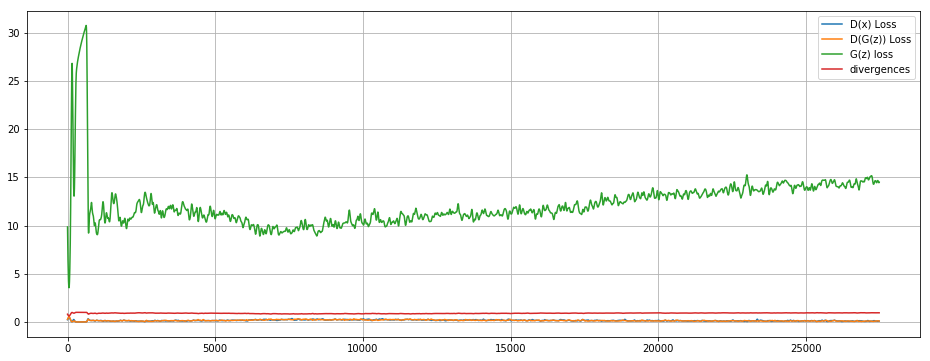

In [10]:
figsize(16, 6)
plot(smooth(d_real_losses), label='D(x) Loss')
plot(smooth(d_fake_losses), label='D(G(z)) Loss')
plot(smooth(g_losses), label='G(z) loss')
plot(smooth(divergences), label='divergences')

grid()
legend()

## Generator Evaluation

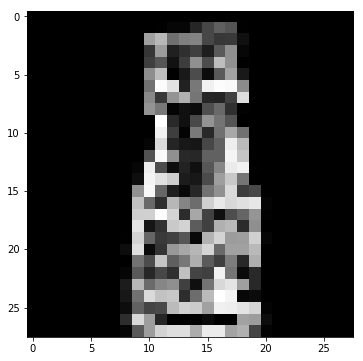

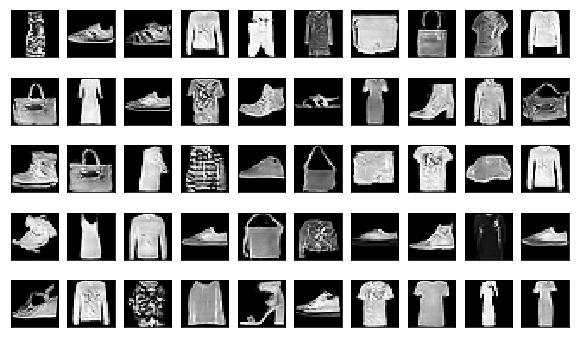

In [11]:
noise = Variable(torch.randn((_batch_size, 100, 1, 1)).cuda())
images = 1-G(noise).view((-1, 28, 28)).data.cpu().numpy()

imshow(images[0], cmap=cm.gray_r)

fig, subplots = pylab.subplots(5, 10) # subplots(y축, x축 갯수)
fig.set_figheight(6)
fig.set_figwidth(10)

idx = 0
for _subs in subplots:
    for subplot in _subs:
        d = images[idx]
        subplot.get_xaxis().set_visible(False)
        subplot.get_yaxis().set_visible(False)
        subplot.imshow(d, cmap=cm.gray_r)
        idx += 1